# Import Required Libraries

In [1]:
WANDB = True
EXP_NAME = "val3-2_convnextv2-tiny_inc-pos100_best_epoch"
# EXP_NAME = "try"

if WANDB:
    # !pip install wandb
    import wandb
    import os
    from dotenv import load_dotenv
    load_dotenv()
    wandb.login(key=os.environ.get("WANDB_API_KEY"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trira7503. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
# from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Training Configuration

In [3]:
CONFIG = {
    "seed": 42,
    "epochs": 30,
    # "epochs": 3, #######　後でなおすこと
    "img_size": 224,
    "model_name": "convnextv2_tiny",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 64,
    "valid_batch_size": 128,
    "learning_rate": 4e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-9,
#     "T_max": 10316,
    "weight_decay": 1e-5,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "use_tta": False,
    "mixup_alpha": 0.4,  # 既存のMixupのパラメータ
    "mixup_epochs": 22,  # Mixupを適用するエポック数を追加
    "dropout_rate": 0.2,
    "warmup_steps": 60,  # Warmupのステップ数を追加
    "warmup_factor": 0.02,  # 初期学習率の倍率
    "save_preds": True,
    "save_dir": "../proc/preds",
    "save_model": True,
    "save_model_dir": f"../proc/models/{EXP_NAME}",
}

In [4]:
if CONFIG["save_model"]:
    if not os.path.exists(CONFIG["save_model_dir"]):
        os.mkdir(CONFIG["save_model_dir"])

# Set Seed for Reproducibility

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [6]:
ROOT_DIR = "../raw"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [7]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# Read the Data

In [8]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [9]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
print(df.shape)
df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

(401059, 55)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,../raw/train-image/image/ISIC_0015670.jpg
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,../raw/train-image/image/ISIC_0015845.jpg
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,../raw/train-image/image/ISIC_0015864.jpg
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,../raw/train-image/image/ISIC_0015902.jpg
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,../raw/train-image/image/ISIC_0024200.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,../raw/train-image/image/ISIC_9999937.jpg
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,../raw/train-image/image/ISIC_9999951.jpg
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,../raw/train-image/image/ISIC_9999960.jpg
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,../raw/train-image/image/ISIC_9999964.jpg


In [10]:
df_patient = df.groupby("patient_id")[["isic_id"]].agg(
    count_per_patient=("isic_id", "count"), 
).sort_values(by="count_per_patient").reset_index()
df_patient.head(2)

,patient_id,count_per_patient
0,IP_5792391,1
1,IP_1487179,1


In [11]:
df = df.merge(df_patient, on="patient_id", how="left")
df.shape[0], df.target.sum()

(401059, 393)

In [12]:
df.shape[0], df.target.sum()

(401059, 393)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [13]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=0)

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)
        
# df[["isic_id", "kfold"]].to_csv("df_fold.csv", index=False)
df[["isic_id", "kfold"]]

,isic_id,kfold
0,ISIC_0015670,4.0
1,ISIC_0015845,2.0
2,ISIC_0015864,1.0
3,ISIC_0015902,2.0
4,ISIC_0024200,1.0
...,...,...
401054,ISIC_9999937,1.0
401055,ISIC_9999951,3.0
401056,ISIC_9999960,0.0
401057,ISIC_9999964,2.0


In [14]:
print(df["target"].sum())
cols_pos = ['ISIC_2008771',
 'ISIC_0107943',
 'ISIC_6773249',
 'ISIC_3400253',
 'ISIC_6468722',
 'ISIC_0940056',
 'ISIC_4173597',
 'ISIC_7957078',
 'ISIC_5219286',
 'ISIC_0173889',
 'ISIC_7590216',
 'ISIC_2122753',
 'ISIC_8626891',
 'ISIC_0718349',
 'ISIC_4646711',
 'ISIC_7681571',
 'ISIC_1795825',
 'ISIC_1725211',
 'ISIC_5076339',
 'ISIC_8481333',
 'ISIC_5473320',
 'ISIC_8775878',
 'ISIC_4087330',
 'ISIC_8849663',
 'ISIC_5849164',
 'ISIC_7453281',
 'ISIC_3850838',
 'ISIC_2874109',
 'ISIC_2716711',
 'ISIC_4783380',
 'ISIC_6334137',
 'ISIC_0632840',
 'ISIC_6023519',
 'ISIC_7435688',
 'ISIC_6674016',
 'ISIC_7476326',
 'ISIC_9229186',
 'ISIC_0538753',
 'ISIC_4695118',
 'ISIC_7592800',
 'ISIC_6058837',
 'ISIC_7488074',
 'ISIC_1915632',
 'ISIC_3001826',
 'ISIC_5518264',
 'ISIC_3887913',
 'ISIC_8848664',
 'ISIC_7310426',
 'ISIC_4559359',
 'ISIC_2643451',
 'ISIC_3261677',
 'ISIC_4264734',
 'ISIC_6402332',
 'ISIC_0609440',
 'ISIC_6650819',
 'ISIC_9203388',
 'ISIC_4434323',
 'ISIC_7577904',
 'ISIC_2089782',
 'ISIC_3518367',
 'ISIC_1862166',
 'ISIC_1879424',
 'ISIC_3668914',
 'ISIC_6454106',
 'ISIC_0917728',
 'ISIC_2462681',
 'ISIC_7406213',
 'ISIC_8013185',
 'ISIC_6507009',
 'ISIC_7259188',
 'ISIC_9639793',
 'ISIC_3032372',
 'ISIC_8538075',
 'ISIC_5885005',
 'ISIC_7269914',
 'ISIC_1131217',
 'ISIC_1753955',
 'ISIC_9298199',
 'ISIC_7257077',
 'ISIC_9097216',
 'ISIC_4453219',
 'ISIC_6305820',
 'ISIC_1677153',
 'ISIC_9039846',
 'ISIC_8086369',
 'ISIC_7849937',
 'ISIC_5662334',
 'ISIC_0528871',
 'ISIC_7533339',
 'ISIC_5765497',
 'ISIC_5182224',
 'ISIC_5119174',
 'ISIC_0848449',
 'ISIC_3134396',
 'ISIC_0914926',
 'ISIC_3506622',
 'ISIC_5023172',
 'ISIC_0270972',
 'ISIC_3140877',
 'ISIC_9675761',
 'ISIC_7086834',
 'ISIC_7050655',
 'ISIC_1828316',
 'ISIC_3902575',
 'ISIC_5361150',
 'ISIC_9146872',
 'ISIC_6240034',
 'ISIC_6931419',
 'ISIC_6782197',
 'ISIC_7436637',
 'ISIC_5022051',
 'ISIC_2085558',
 'ISIC_4616252',
 'ISIC_0472484',
 'ISIC_7801895',
 'ISIC_2747138',
 'ISIC_5678980',
 'ISIC_1168563',
 'ISIC_9988581',
 'ISIC_8292121',
 'ISIC_8996327',
 'ISIC_1948223',
 'ISIC_6348374',
 'ISIC_0967190',
 'ISIC_8939581',
 'ISIC_6087072',
 'ISIC_2221374',
 'ISIC_4700313',
 'ISIC_2149029',
 'ISIC_8820942',
 'ISIC_5985734',
 'ISIC_0582631',
 'ISIC_8867380',
 'ISIC_0932118',
 'ISIC_6894830',
 'ISIC_9989718',
 'ISIC_8277996',
 'ISIC_4714490',
 'ISIC_3684353',
 'ISIC_9368520',
 'ISIC_3505855',
 'ISIC_8688899',
 'ISIC_4353025',
 'ISIC_2105198',
 'ISIC_5444768',
 'ISIC_0620681',
 'ISIC_9401984',
 'ISIC_4496734',
 'ISIC_6641966',
 'ISIC_7758793',
 'ISIC_0439729',
 'ISIC_1764526',
 'ISIC_4004565',
 'ISIC_6959619',
 'ISIC_1621277',
 'ISIC_0758557',
 'ISIC_7997709',
 'ISIC_8326053',
 'ISIC_0340178',
 'ISIC_9390683',
 'ISIC_4420538',
 'ISIC_5539640',
 'ISIC_8542598',
 'ISIC_1026589',
 'ISIC_1289545',
 'ISIC_8516842',
 'ISIC_6205874',
 'ISIC_0563319',
 'ISIC_0780208',
 'ISIC_1191502',
 'ISIC_1025085',
 'ISIC_2736960',
 'ISIC_8461522',
 'ISIC_4166664',
 'ISIC_6046688',
 'ISIC_8910904',
 'ISIC_3669062',
 'ISIC_1767915',
 'ISIC_8696844',
 'ISIC_4293366',
 'ISIC_7668587',
 'ISIC_8719744',
 'ISIC_6092706',
 'ISIC_2283929',
 'ISIC_3439605',
 'ISIC_6305381',
 'ISIC_5056174',
 'ISIC_5715703',
 'ISIC_9218252',
 'ISIC_9105322',
 'ISIC_3530806',
 'ISIC_7746679',
 'ISIC_6094199',
 'ISIC_2592061',
 'ISIC_9720183',
 'ISIC_5413740',
 'ISIC_3658088',
 'ISIC_6144928',
 'ISIC_8725970',
 'ISIC_9167063',
 'ISIC_7114844',
 'ISIC_9081793',
 'ISIC_2933421',
 'ISIC_6163825',
 'ISIC_6800695',
 'ISIC_3815659',
 'ISIC_5754810',
 'ISIC_8797926',
 'ISIC_1459374',
 'ISIC_2972523',
 'ISIC_5301714',
 'ISIC_9834289',
 'ISIC_0838711',
 'ISIC_4629715',
 'ISIC_9758154',
 'ISIC_9861997',
 'ISIC_8695576',
 'ISIC_9325482',
 'ISIC_0377274',
 'ISIC_3373460',
 'ISIC_8297496',
 'ISIC_8659663',
 'ISIC_7861792',
 'ISIC_7948199',
 'ISIC_2400763',
 'ISIC_4478794',
 'ISIC_2871853',
 'ISIC_6972269',
 'ISIC_9015553',
 'ISIC_0015845',
 'ISIC_2444245',
 'ISIC_1996069',
 'ISIC_5044892',
 'ISIC_0351339',
 'ISIC_0860780',
 'ISIC_6346300',
 'ISIC_5365924',
 'ISIC_6364442',
 'ISIC_3420650',
 'ISIC_5331975',
 'ISIC_1121162',
 'ISIC_0296335',
 'ISIC_7749030',
 'ISIC_4741457',
 'ISIC_2381279',
 'ISIC_7487113',
 'ISIC_1239252',
 'ISIC_1042583',
 'ISIC_2194880',
 'ISIC_7107379',
 'ISIC_1494758',
 'ISIC_1752095',
 'ISIC_0704755',
 'ISIC_9783183',
 'ISIC_9617684',
 'ISIC_6027500',
 'ISIC_5778946',
 'ISIC_6253821',
 'ISIC_8882986',
 'ISIC_1589224',
 'ISIC_0640511',
 'ISIC_1825785',
 'ISIC_5203845',
 'ISIC_2056542',
 'ISIC_3200101',
 'ISIC_5033087',
 'ISIC_3311192',
 'ISIC_8730888',
 'ISIC_6913761',
 'ISIC_4256704',
 'ISIC_3976425',
 'ISIC_4046261',
 'ISIC_3408909',
 'ISIC_6371364',
 'ISIC_6836587',
 'ISIC_7266752',
 'ISIC_6257552',
 'ISIC_9956455',
 'ISIC_5620845',
 'ISIC_9059784',
 'ISIC_1565170',
 'ISIC_4892145',
 'ISIC_5088258',
 'ISIC_0179858',
 'ISIC_6218718',
 'ISIC_7246302',
 'ISIC_0495967',
 'ISIC_9320159',
 'ISIC_5192778',
 'ISIC_0210159',
 'ISIC_1245444',
 'ISIC_9105116',
 'ISIC_3572499',
 'ISIC_2532733',
 'ISIC_5990191',
 'ISIC_3728494',
 'ISIC_4526825',
 'ISIC_6091741',
 'ISIC_4068632',
 'ISIC_7022250',
 'ISIC_1110208',
 'ISIC_6658007',
 'ISIC_2920305',
 'ISIC_8744037',
 'ISIC_6187033',
 'ISIC_4685649',
 'ISIC_6611476',
 'ISIC_1764886',
 'ISIC_8013573',
 'ISIC_3388796',
 'ISIC_3539750',
 'ISIC_4849828',
 'ISIC_2174953',
 'ISIC_2323337',
 'ISIC_9976949',
 'ISIC_3327285',
 'ISIC_4605811',
 'ISIC_4433275',
 'ISIC_7686886',
 'ISIC_1067206',
 'ISIC_2100625',
 'ISIC_5896728',
 'ISIC_0235913',
 'ISIC_3294660',
 'ISIC_3800350',
 'ISIC_1535063',
 'ISIC_0657475',
 'ISIC_2563069',
 'ISIC_9027229',
 'ISIC_5061867',
 'ISIC_9149070',
 'ISIC_0510301',
 'ISIC_0188892',
 'ISIC_2323977',
 'ISIC_1772613',
 'ISIC_4083562',
 'ISIC_9631653',
 'ISIC_6610493',
 'ISIC_2938080',
 'ISIC_8759710',
 'ISIC_7698480',
 'ISIC_5756321',
 'ISIC_2036691',
 'ISIC_9034396',
 'ISIC_5706697',
 'ISIC_2585247',
 'ISIC_2624879',
 'ISIC_9923515',
 'ISIC_7254044',
 'ISIC_3616556',
 'ISIC_7095002',
 'ISIC_4597546',
 'ISIC_1464154',
 'ISIC_0392047',
 'ISIC_1934188',
 'ISIC_5216878',
 'ISIC_2854835',
 'ISIC_1227476',
 'ISIC_3091114',
 'ISIC_1245087',
 'ISIC_8290600',
 'ISIC_8630375',
 'ISIC_3067434',
 'ISIC_7980486',
 'ISIC_3518376',
 'ISIC_6713047',
 'ISIC_3427672',
 'ISIC_3086424',
 'ISIC_6690296',
 'ISIC_8014469',
 'ISIC_2323160',
 'ISIC_2958209',
 'ISIC_3293774',
 'ISIC_2510305',
 'ISIC_0493373',
 'ISIC_7106394',
 'ISIC_2634375',
 'ISIC_1215450',
 'ISIC_9821218',
 'ISIC_2240793',
 'ISIC_6715917',
 'ISIC_8659459',
 'ISIC_0148582',
 'ISIC_5170761',
 'ISIC_7769815',
 'ISIC_0631326',
 'ISIC_9969302',
 'ISIC_5265464',
 'ISIC_2571748',
 'ISIC_9797963',
 'ISIC_0395316',
 'ISIC_1348100',
 'ISIC_2037946',
 'ISIC_8314797',
 'ISIC_8745545',
 'ISIC_5745161',
 'ISIC_3249657',
 'ISIC_0504035',
 'ISIC_6459369',
 'ISIC_7795931',
 'ISIC_1976646',
 'ISIC_1262019',
 'ISIC_1862557',
 'ISIC_8612102',
 'ISIC_4322900',
 'ISIC_1483099',
 'ISIC_8230285',
 'ISIC_2516455',
 'ISIC_8979666',
 'ISIC_9664961',
 'ISIC_4544598',
 'ISIC_0824663',
 'ISIC_9195989',
 'ISIC_7620735',
 'ISIC_4932158',
 'ISIC_0496482',
 'ISIC_9828567',
 'ISIC_3637517',
 'ISIC_1411822',
 'ISIC_8167488',
 'ISIC_7800626',
 'ISIC_5353496',
 'ISIC_2470540',
 'ISIC_2865725',
 'ISIC_2347724',
 'ISIC_6618102',
 'ISIC_2295901',
 'ISIC_7992260',
 'ISIC_9001660',
 'ISIC_8906487',
 'ISIC_5731571',
 'ISIC_9066911',
 'ISIC_2175101',
 'ISIC_2095492',
 'ISIC_6703801',
 'ISIC_6560451',
 'ISIC_0807301',
 'ISIC_6360744',
 'ISIC_0809631',
 'ISIC_9389521',
 'ISIC_2116022',
 'ISIC_0432088',
 'ISIC_6735323',
 'ISIC_6949718',
 'ISIC_8892501',
 'ISIC_4912065',
 'ISIC_4259356',
 'ISIC_9169405',
 'ISIC_3486195',
 'ISIC_4993922',
 'ISIC_5443666',
 'ISIC_5701641',
 'ISIC_9246981',
 'ISIC_5370388',
 'ISIC_7267851',
 'ISIC_1471931',
 'ISIC_6569920',
 'ISIC_4627130',
 'ISIC_6309621',
 'ISIC_4666996',
 'ISIC_4774591',
 'ISIC_8374510',
 'ISIC_0951368',
 'ISIC_8863460',
 'ISIC_4154526',
 'ISIC_8258032',
 'ISIC_3526261',
 'ISIC_6563912',
 'ISIC_1345438',
 'ISIC_0827685',
 'ISIC_9289794',
 'ISIC_4741592',
 'ISIC_0584682',
 'ISIC_9568302',
 'ISIC_3301600',
 'ISIC_8459863',
 'ISIC_7230017',
 'ISIC_6060936',
 'ISIC_1820205',
 'ISIC_7733792',
 'ISIC_0246502',
 'ISIC_6558532',
 'ISIC_7058606',
 'ISIC_2386940',
 'ISIC_1936200',
 'ISIC_2150057',
 'ISIC_3205951',
 'ISIC_5500255',
 'ISIC_3432892',
 'ISIC_9424702',
 'ISIC_8898211',
 'ISIC_1583457',
 'ISIC_6970878',
 'ISIC_4242510',
 'ISIC_4489462',
 'ISIC_8228446',
 'ISIC_9113203',
 'ISIC_2123266',
 'ISIC_9145048',
 'ISIC_4187658']

df["target_original"] = df["target"]
df.loc[df["isic_id"].isin(cols_pos), "target"] = 1
print(df["target"].sum())

393
893


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [15]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [16]:
# Mixupを行う関数を追加
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Batch size should be larger than 1"

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [17]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [18]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        # xの次元数が4（バッチ、チャネル、高さ、幅）であることを確認
        if x.dim() != 4:
            raise ValueError(f'Expected 4D input (got {x.dim()}D input)')
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [19]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None, dropout_rate=CONFIG['dropout_rate']):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

        # モデルの出力サイズを取得
        if hasattr(self.model, 'num_features'):
            in_features = self.model.num_features  # num_featuresで取得するモデルが多い
        elif hasattr(self.model, 'classifier') and hasattr(self.model.classifier, 'in_features'):
            in_features = self.model.classifier.in_features  # classifierが存在する場合
        elif hasattr(self.model, 'fc') and hasattr(self.model.fc, 'in_features'):
            in_features = self.model.fc.in_features  # fcが存在する場合
        else:
            raise AttributeError("Could not find the output feature size.")

        # モデルのヘッド部分をIdentityで置き換え
        self.model.reset_classifier(0)  # timmで全結合層をリセットする簡単な方法

        # カスタム層
        self.pooling = GeM()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model.forward_features(images)  # ここを変更
        pooled_features = self.pooling(features).flatten(1)
        dropped_features = self.dropout(pooled_features)
        output = self.sigmoid(self.linear(dropped_features))
        return output


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [20]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)
#     return nn.CrossEntropyLoss()(outputs, targets) 

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [21]:
def comp_score_list(solution: list, submission: list, min_tpr: float=0.80):
    v_gt = np.abs(np.array(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [22]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # Mixupを設定されたエポック数まで適用
        if epoch <= CONFIG['mixup_epochs']:
            mixed_images, targets_a, targets_b, lam = mixup(images, targets, alpha=CONFIG['mixup_alpha'])
            outputs = model(mixed_images).squeeze()
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [23]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    # TTAのためのカウンター
    tta_counter = 0
    
    # TTAのための関数を定義
    def apply_tta(model, image):
        outputs = []
        
        # オリジナル画像
        outputs.append(model(image).squeeze())
        
        # 水平フリップ
        outputs.append(model(torch.flip(image, dims=[3])).squeeze())
        
        # 垂直フリップ
        outputs.append(model(torch.flip(image, dims=[2])).squeeze())
        
        # 90度、180度、270度回転
        for k in [1, 2, 3]:
            outputs.append(model(torch.rot90(image, k, dims=[2,3])).squeeze())
        
        return torch.stack(outputs).mean(dim=0)
    
    all_outputs = []
    all_targets = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        if CONFIG['use_tta']:
            outputs = apply_tta(model, images).squeeze()
        else:
            outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        all_outputs.extend(outputs.detach().cpu().numpy().flatten())  # 確率に変換して蓄積
        all_targets.extend(targets.detach().cpu().numpy().flatten())  # ラベルを蓄積

#         auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, 
                        LR=optimizer.param_groups[0]['lr'])   
    
    # epoch毎にauroc算出
    epoch_auroc = comp_score_list(all_targets, all_outputs)
    
    gc.collect()
    
    return epoch_loss, epoch_auroc, all_outputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [24]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    save_dir = CONFIG["save_model_dir"]
    df_best_pred = df.loc[df["kfold"]==fold, ["isic_id", "target"]]
    PATH_BEST = None
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, outputs_np = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=epoch
        )
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append(scheduler.get_last_lr()[0])
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc:.5f} ---> {val_epoch_auroc:.5f})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH_BEST = "{}/fold{}_pAUC{:.4f}_epoch{:.0f}.bin".format(CONFIG["save_model_dir"], fold, val_epoch_auroc, epoch)

        else:
            print(f"Validation pAUC80 not Improved ({val_epoch_auroc:.5f})")

        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # if CONFIG['save_model']:
        # ベストのモデルを保存する
        # if PATH_BEST is not None:
        #     torch.save(best_model_wts, PATH_BEST)
    
        # 最後のモデルを保存する
        # PATH = "{}/pAUC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG["save_model_dir"], val_epoch_auroc, val_epoch_loss, epoch)
        # torch.save(model.state_dict(), PATH)
    
    return model, history

In [25]:
class WarmupScheduler:
    def __init__(self, optimizer, warmup_steps, warmup_factor, base_scheduler):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.warmup_factor = warmup_factor
        self.base_scheduler = base_scheduler
        self.current_step = 0

    def step(self):
        self.current_step += 1
        if self.current_step < self.warmup_steps:
            lr_scale = self.warmup_factor + (1 - self.warmup_factor) * (self.current_step / self.warmup_steps)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr_scale * param_group['initial_lr']
        else:
            self.base_scheduler.step()

    def get_last_lr(self):
        if self.current_step < self.warmup_steps:
            lr_scale = self.warmup_factor + (1 - self.warmup_factor) * (self.current_step / self.warmup_steps)
            return [lr_scale * param_group['initial_lr'] for param_group in self.optimizer.param_groups]
        else:
            return self.base_scheduler.get_last_lr()

def fetch_scheduler(optimizer, T_max=None):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        base_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        base_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG['T_0'], eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    return WarmupScheduler(optimizer, CONFIG['warmup_steps'], CONFIG['warmup_factor'], base_scheduler)


In [26]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

# CV

In [27]:
# wandbの初期化
if WANDB:
    wandb_config = {
        # ... 既存の設定 ...
        "epochs": CONFIG['epochs'],
        "learning_rate": CONFIG['learning_rate'],
        "min_lr": CONFIG["min_lr"],
        "weight_decay": CONFIG["weight_decay"],
        "mixup_alpha": CONFIG["mixup_alpha"],
        "mixup_epochs": CONFIG["mixup_epochs"],  # 新しく追加
    }
    wandb.init(project="ISIC2024_images", name=EXP_NAME, config=wandb_config)

In [28]:
list_score_notFiltered = []
list_preds = []
for fold in range(CONFIG["n_fold"]):
    print("==="*10)
    print(f"fold {fold}")
    print("==="*10)
    
    df_train = df[df["kfold"]!=fold]
    df_val = df[df["kfold"]==fold]
    df_val["target"] = df_val["target_original"]

    # trainのダウンサンプリング
    print("●train")
    print("original>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    df_positive = df_train[df_train["target"] == 1].reset_index(drop=True)
    df_negative = df_train[df_train["target"] == 0].sample(n=df_positive.shape[0]*10, random_state=0) # ランダムに抽出
    df_train = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    
    # valのダウンサンプリング
    print("●val")
    print("original>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    df_positive = df_val[df_val["target"] == 1].reset_index(drop=True)
    df_negative = df_val[df_val["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_val = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    
    # いったん全データ結合
    df_fold = pd.concat((df_train, df_val)).reset_index(drop=True)
    del df_train, df_val
    
    model = ISICModel(CONFIG['model_name'], pretrained=True)
    model.to(CONFIG['device']);
    
    # 最後のfoldだけ勾配を記録する うまく行ってるのかよくわからん
#     if fold==4 and WANDB:
#         wandb.watch(model, log="all", log_freq=1)
    
    train_loader, valid_loader = prepare_loaders(df_fold, fold=fold)
    # optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
    #                         weight_decay=CONFIG['weight_decay'])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    T_max = len(train_loader) * CONFIG["epochs"] - CONFIG["warmup_steps"]
    scheduler = fetch_scheduler(optimizer, T_max=T_max)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    history = pd.DataFrame.from_dict(history)
    history.to_csv(f"{CONFIG['save_dir']}/history_fold{fold}.csv", index=False)

    #########################
    # valの全データでスコア確認
    #########################
    df_val = df[df["kfold"]==fold]
    df_val["target"] = df_val["target_original"]
    df_val_pred = df_val[["isic_id", "kfold", "target"]]

    model.eval()
    
    valid_dataset = ISICDataset(df_val, transforms=data_transforms["valid"])
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    preds = []
    with torch.inference_mode():
        bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, data in bar:        
            images = data['image'].to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            outputs = model(images).squeeze()
            preds.extend(outputs.detach().cpu().numpy().flatten())
    
    df_val_pred["preds"] = preds
    list_preds.append(df_val_pred)

    # マルチクラス用のpAUC計算
    epoch_pauc = comp_score_list(df_val["target"].to_list(), preds)
    print(f"fold{fold}_pAUC (not filtered): {epoch_pauc:.4f}")
    list_score_notFiltered.append(epoch_pauc)
    
    # 不要なメモリを開放
    del model, optimizer, scheduler, train_loader, valid_loader, history
    torch.cuda.empty_cache()

fold 0
●train
original> (306580, 59) 720 (835,)
filtered> (7920, 59) 720 (781,)
●val
original> (94479, 59) 73 (207,)
filtered> (1533, 59) 73 (180,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:01<00:00,  6.78it/s, Epoch=1, LR=1.52e-5, Valid_Loss=0.502]


Validation AUROC Improved (-inf ---> 0.05783)



100%|██████████| 12/12 [00:01<00:00,  7.53it/s, Epoch=2, LR=2.95e-5, Valid_Loss=0.351]


Validation AUROC Improved (0.05783 ---> 0.08428)



100%|██████████| 12/12 [00:01<00:00,  7.68it/s, Epoch=3, LR=3.93e-5, Valid_Loss=0.295]


Validation AUROC Improved (0.08428 ---> 0.10246)



100%|██████████| 12/12 [00:01<00:00,  7.56it/s, Epoch=4, LR=3.91e-5, Valid_Loss=0.313]


Validation AUROC Improved (0.10246 ---> 0.12921)



100%|██████████| 12/12 [00:01<00:00,  7.47it/s, Epoch=5, LR=3.86e-5, Valid_Loss=0.227]


Validation AUROC Improved (0.12921 ---> 0.13594)



100%|██████████| 12/12 [00:01<00:00,  7.45it/s, Epoch=6, LR=3.79e-5, Valid_Loss=0.182]


Validation AUROC Improved (0.13594 ---> 0.13604)



100%|██████████| 12/12 [00:01<00:00,  7.33it/s, Epoch=7, LR=3.7e-5, Valid_Loss=0.203]


Validation AUROC Improved (0.13604 ---> 0.13699)



100%|██████████| 12/12 [00:01<00:00,  7.41it/s, Epoch=8, LR=3.58e-5, Valid_Loss=0.359]


Validation AUROC Improved (0.13699 ---> 0.13806)



100%|██████████| 12/12 [00:01<00:00,  7.70it/s, Epoch=9, LR=3.44e-5, Valid_Loss=0.296]


Validation pAUC80 not Improved (0.13536)



100%|██████████| 12/12 [00:01<00:00,  7.49it/s, Epoch=10, LR=3.28e-5, Valid_Loss=0.26] 


Validation AUROC Improved (0.13806 ---> 0.14510)



100%|██████████| 12/12 [00:01<00:00,  7.64it/s, Epoch=11, LR=3.1e-5, Valid_Loss=0.276]


Validation pAUC80 not Improved (0.14201)



100%|██████████| 12/12 [00:01<00:00,  7.45it/s, Epoch=12, LR=2.91e-5, Valid_Loss=0.193]


Validation pAUC80 not Improved (0.14194)



100%|██████████| 12/12 [00:01<00:00,  7.47it/s, Epoch=13, LR=2.7e-5, Valid_Loss=0.235]


Validation AUROC Improved (0.14510 ---> 0.14983)



100%|██████████| 12/12 [00:01<00:00,  7.65it/s, Epoch=14, LR=2.49e-5, Valid_Loss=0.272]


Validation pAUC80 not Improved (0.14691)



100%|██████████| 12/12 [00:01<00:00,  7.51it/s, Epoch=15, LR=2.26e-5, Valid_Loss=0.176]


Validation AUROC Improved (0.14983 ---> 0.15193)



100%|██████████| 12/12 [00:01<00:00,  7.48it/s, Epoch=16, LR=2.04e-5, Valid_Loss=0.193]


Validation pAUC80 not Improved (0.15129)



100%|██████████| 12/12 [00:01<00:00,  7.49it/s, Epoch=17, LR=1.81e-5, Valid_Loss=0.171]


Validation pAUC80 not Improved (0.14960)



100%|██████████| 12/12 [00:01<00:00,  7.44it/s, Epoch=18, LR=1.59e-5, Valid_Loss=0.286]


Validation pAUC80 not Improved (0.14324)



100%|██████████| 12/12 [00:01<00:00,  7.49it/s, Epoch=19, LR=1.37e-5, Valid_Loss=0.184]


Validation pAUC80 not Improved (0.15110)



100%|██████████| 12/12 [00:01<00:00,  7.72it/s, Epoch=20, LR=1.16e-5, Valid_Loss=0.187]


Validation pAUC80 not Improved (0.15009)



100%|██████████| 12/12 [00:01<00:00,  7.67it/s, Epoch=21, LR=9.57e-6, Valid_Loss=0.237]


Validation pAUC80 not Improved (0.15001)



100%|██████████| 12/12 [00:01<00:00,  7.60it/s, Epoch=22, LR=7.7e-6, Valid_Loss=0.199]


Validation pAUC80 not Improved (0.14282)



100%|██████████| 12/12 [00:01<00:00,  7.68it/s, Epoch=23, LR=5.98e-6, Valid_Loss=0.182]


Validation pAUC80 not Improved (0.14720)



100%|██████████| 12/12 [00:01<00:00,  7.52it/s, Epoch=24, LR=4.45e-6, Valid_Loss=0.196]


Validation pAUC80 not Improved (0.14290)



100%|██████████| 12/12 [00:01<00:00,  7.54it/s, Epoch=25, LR=3.12e-6, Valid_Loss=0.21] 


Validation AUROC Improved (0.15193 ---> 0.15313)



100%|██████████| 12/12 [00:01<00:00,  7.53it/s, Epoch=26, LR=2.01e-6, Valid_Loss=0.184]


Validation pAUC80 not Improved (0.14745)



100%|██████████| 12/12 [00:01<00:00,  7.42it/s, Epoch=27, LR=1.13e-6, Valid_Loss=0.181]


Validation pAUC80 not Improved (0.15025)



100%|██████████| 12/12 [00:01<00:00,  7.47it/s, Epoch=28, LR=4.98e-7, Valid_Loss=0.199]


Validation pAUC80 not Improved (0.15157)



100%|██████████| 12/12 [00:01<00:00,  7.48it/s, Epoch=29, LR=1.2e-7, Valid_Loss=0.191]


Validation pAUC80 not Improved (0.15144)



100%|██████████| 12/12 [00:01<00:00,  7.70it/s, Epoch=30, LR=1.27e-9, Valid_Loss=0.19] 


Validation pAUC80 not Improved (0.15134)

Training complete in 0h 4m 1s
Best AUROC: 0.1531


100%|██████████| 739/739 [01:19<00:00,  9.35it/s]


fold0_pAUC (not filtered): 0.1509
fold 1
●train
original> (315046, 59) 697 (833,)
filtered> (7667, 59) 697 (760,)
●val
original> (86013, 59) 96 (209,)
filtered> (2016, 59) 96 (195,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 16/16 [00:02<00:00,  7.88it/s, Epoch=1, LR=1.45e-5, Valid_Loss=0.406]


Validation AUROC Improved (-inf ---> 0.05337)



100%|██████████| 16/16 [00:01<00:00,  8.15it/s, Epoch=2, LR=2.82e-5, Valid_Loss=0.42] 


Validation AUROC Improved (0.05337 ---> 0.10011)



100%|██████████| 16/16 [00:01<00:00,  8.24it/s, Epoch=3, LR=3.93e-5, Valid_Loss=0.367]


Validation AUROC Improved (0.10011 ---> 0.13690)



100%|██████████| 16/16 [00:02<00:00,  7.86it/s, Epoch=4, LR=3.92e-5, Valid_Loss=0.347]


Validation AUROC Improved (0.13690 ---> 0.14477)



100%|██████████| 16/16 [00:01<00:00,  8.11it/s, Epoch=5, LR=3.87e-5, Valid_Loss=0.301]


Validation AUROC Improved (0.14477 ---> 0.15345)



100%|██████████| 16/16 [00:01<00:00,  8.13it/s, Epoch=6, LR=3.8e-5, Valid_Loss=0.307]


Validation AUROC Improved (0.15345 ---> 0.15615)



100%|██████████| 16/16 [00:01<00:00,  8.05it/s, Epoch=7, LR=3.71e-5, Valid_Loss=0.276]


Validation AUROC Improved (0.15615 ---> 0.16050)



100%|██████████| 16/16 [00:01<00:00,  8.13it/s, Epoch=8, LR=3.59e-5, Valid_Loss=0.38] 


Validation AUROC Improved (0.16050 ---> 0.16099)



100%|██████████| 16/16 [00:01<00:00,  8.16it/s, Epoch=9, LR=3.45e-5, Valid_Loss=0.247]


Validation AUROC Improved (0.16099 ---> 0.16576)



100%|██████████| 16/16 [00:01<00:00,  8.08it/s, Epoch=10, LR=3.29e-5, Valid_Loss=0.196]


Validation pAUC80 not Improved (0.15933)



100%|██████████| 16/16 [00:01<00:00,  8.10it/s, Epoch=11, LR=3.11e-5, Valid_Loss=0.253]


Validation pAUC80 not Improved (0.15949)



100%|██████████| 16/16 [00:01<00:00,  8.04it/s, Epoch=12, LR=2.92e-5, Valid_Loss=0.235]


Validation AUROC Improved (0.16576 ---> 0.16696)



100%|██████████| 16/16 [00:01<00:00,  8.20it/s, Epoch=13, LR=2.72e-5, Valid_Loss=0.263]


Validation pAUC80 not Improved (0.16525)



100%|██████████| 16/16 [00:01<00:00,  8.12it/s, Epoch=14, LR=2.5e-5, Valid_Loss=0.242]


Validation pAUC80 not Improved (0.16543)



100%|██████████| 16/16 [00:01<00:00,  8.15it/s, Epoch=15, LR=2.28e-5, Valid_Loss=0.223]


Validation pAUC80 not Improved (0.16480)



100%|██████████| 16/16 [00:01<00:00,  8.13it/s, Epoch=16, LR=2.05e-5, Valid_Loss=0.187]


Validation pAUC80 not Improved (0.16607)



100%|██████████| 16/16 [00:01<00:00,  8.17it/s, Epoch=17, LR=1.83e-5, Valid_Loss=0.216]


Validation AUROC Improved (0.16696 ---> 0.16748)



100%|██████████| 16/16 [00:01<00:00,  8.19it/s, Epoch=18, LR=1.6e-5, Valid_Loss=0.216]


Validation AUROC Improved (0.16748 ---> 0.16814)



100%|██████████| 16/16 [00:01<00:00,  8.04it/s, Epoch=19, LR=1.38e-5, Valid_Loss=0.25] 


Validation AUROC Improved (0.16814 ---> 0.16870)



100%|██████████| 16/16 [00:01<00:00,  8.21it/s, Epoch=20, LR=1.17e-5, Valid_Loss=0.205]


Validation AUROC Improved (0.16870 ---> 0.16953)



100%|██████████| 16/16 [00:01<00:00,  8.11it/s, Epoch=21, LR=9.65e-6, Valid_Loss=0.204]


Validation pAUC80 not Improved (0.16752)



100%|██████████| 16/16 [00:01<00:00,  8.18it/s, Epoch=22, LR=7.76e-6, Valid_Loss=0.171]


Validation AUROC Improved (0.16953 ---> 0.17056)



100%|██████████| 16/16 [00:01<00:00,  8.16it/s, Epoch=23, LR=6.03e-6, Valid_Loss=0.208]


Validation pAUC80 not Improved (0.16982)



100%|██████████| 16/16 [00:01<00:00,  8.11it/s, Epoch=24, LR=4.49e-6, Valid_Loss=0.207]


Validation AUROC Improved (0.17056 ---> 0.17100)



100%|██████████| 16/16 [00:01<00:00,  8.17it/s, Epoch=25, LR=3.15e-6, Valid_Loss=0.22] 


Validation AUROC Improved (0.17100 ---> 0.17188)



100%|██████████| 16/16 [00:01<00:00,  8.20it/s, Epoch=26, LR=2.02e-6, Valid_Loss=0.188]


Validation pAUC80 not Improved (0.17097)



100%|██████████| 16/16 [00:01<00:00,  8.13it/s, Epoch=27, LR=1.14e-6, Valid_Loss=0.189]


Validation pAUC80 not Improved (0.17105)



100%|██████████| 16/16 [00:01<00:00,  8.11it/s, Epoch=28, LR=5.01e-7, Valid_Loss=0.197]


Validation pAUC80 not Improved (0.17130)



100%|██████████| 16/16 [00:01<00:00,  8.15it/s, Epoch=29, LR=1.2e-7, Valid_Loss=0.202]


Validation pAUC80 not Improved (0.17145)



100%|██████████| 16/16 [00:01<00:00,  8.09it/s, Epoch=30, LR=1.3e-9, Valid_Loss=0.202]


Validation pAUC80 not Improved (0.17143)

Training complete in 0h 4m 9s
Best AUROC: 0.1719


100%|██████████| 672/672 [01:11<00:00,  9.36it/s]


fold1_pAUC (not filtered): 0.1701
fold 2
●train
original> (326063, 59) 735 (833,)
filtered> (8085, 59) 735 (775,)
●val
original> (74996, 59) 58 (209,)
filtered> (1218, 59) 58 (186,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 10/10 [00:01<00:00,  7.43it/s, Epoch=1, LR=1.52e-5, Valid_Loss=0.688]


Validation AUROC Improved (-inf ---> 0.07921)



100%|██████████| 10/10 [00:01<00:00,  7.70it/s, Epoch=2, LR=2.95e-5, Valid_Loss=0.374]


Validation AUROC Improved (0.07921 ---> 0.12346)



100%|██████████| 10/10 [00:01<00:00,  7.74it/s, Epoch=3, LR=3.93e-5, Valid_Loss=0.449]


Validation AUROC Improved (0.12346 ---> 0.14539)



100%|██████████| 10/10 [00:01<00:00,  7.58it/s, Epoch=4, LR=3.91e-5, Valid_Loss=0.464]


Validation AUROC Improved (0.14539 ---> 0.14931)



100%|██████████| 10/10 [00:01<00:00,  7.76it/s, Epoch=5, LR=3.86e-5, Valid_Loss=0.49]


Validation AUROC Improved (0.14931 ---> 0.15093)



100%|██████████| 10/10 [00:01<00:00,  7.73it/s, Epoch=6, LR=3.79e-5, Valid_Loss=0.415]


Validation AUROC Improved (0.15093 ---> 0.15820)



100%|██████████| 10/10 [00:01<00:00,  7.72it/s, Epoch=7, LR=3.7e-5, Valid_Loss=0.344]


Validation pAUC80 not Improved (0.15248)



100%|██████████| 10/10 [00:01<00:00,  7.71it/s, Epoch=8, LR=3.58e-5, Valid_Loss=0.361]


Validation pAUC80 not Improved (0.15626)



100%|██████████| 10/10 [00:01<00:00,  7.62it/s, Epoch=9, LR=3.44e-5, Valid_Loss=0.318]


Validation AUROC Improved (0.15820 ---> 0.15969)



100%|██████████| 10/10 [00:01<00:00,  7.76it/s, Epoch=10, LR=3.28e-5, Valid_Loss=0.328]


Validation AUROC Improved (0.15969 ---> 0.16059)



100%|██████████| 10/10 [00:01<00:00,  7.63it/s, Epoch=11, LR=3.1e-5, Valid_Loss=0.261]


Validation pAUC80 not Improved (0.15870)



100%|██████████| 10/10 [00:01<00:00,  7.72it/s, Epoch=12, LR=2.91e-5, Valid_Loss=0.294]


Validation pAUC80 not Improved (0.15878)



100%|██████████| 10/10 [00:01<00:00,  7.79it/s, Epoch=13, LR=2.7e-5, Valid_Loss=0.375]


Validation pAUC80 not Improved (0.15910)



100%|██████████| 10/10 [00:01<00:00,  7.79it/s, Epoch=14, LR=2.49e-5, Valid_Loss=0.23]


Validation AUROC Improved (0.16059 ---> 0.16212)



100%|██████████| 10/10 [00:01<00:00,  7.74it/s, Epoch=15, LR=2.26e-5, Valid_Loss=0.288]


Validation AUROC Improved (0.16212 ---> 0.16475)



100%|██████████| 10/10 [00:01<00:00,  7.80it/s, Epoch=16, LR=2.04e-5, Valid_Loss=0.311]


Validation pAUC80 not Improved (0.16129)



100%|██████████| 10/10 [00:01<00:00,  7.75it/s, Epoch=17, LR=1.81e-5, Valid_Loss=0.245]


Validation pAUC80 not Improved (0.16374)



100%|██████████| 10/10 [00:01<00:00,  7.69it/s, Epoch=18, LR=1.59e-5, Valid_Loss=0.217]


Validation pAUC80 not Improved (0.16324)



100%|██████████| 10/10 [00:01<00:00,  7.69it/s, Epoch=19, LR=1.37e-5, Valid_Loss=0.25]


Validation pAUC80 not Improved (0.16439)



100%|██████████| 10/10 [00:01<00:00,  7.72it/s, Epoch=20, LR=1.16e-5, Valid_Loss=0.24]


Validation pAUC80 not Improved (0.16378)



100%|██████████| 10/10 [00:01<00:00,  7.79it/s, Epoch=21, LR=9.57e-6, Valid_Loss=0.226]


Validation pAUC80 not Improved (0.16445)



100%|██████████| 10/10 [00:01<00:00,  7.62it/s, Epoch=22, LR=7.7e-6, Valid_Loss=0.241]


Validation pAUC80 not Improved (0.16474)



100%|██████████| 10/10 [00:01<00:00,  7.77it/s, Epoch=23, LR=5.98e-6, Valid_Loss=0.256]


Validation pAUC80 not Improved (0.16461)



100%|██████████| 10/10 [00:01<00:00,  7.69it/s, Epoch=24, LR=4.45e-6, Valid_Loss=0.319]


Validation pAUC80 not Improved (0.16049)



100%|██████████| 10/10 [00:01<00:00,  7.63it/s, Epoch=25, LR=3.12e-6, Valid_Loss=0.283]


Validation pAUC80 not Improved (0.16310)



100%|██████████| 10/10 [00:01<00:00,  7.65it/s, Epoch=26, LR=2.01e-6, Valid_Loss=0.244]


Validation pAUC80 not Improved (0.16223)



100%|██████████| 10/10 [00:01<00:00,  7.72it/s, Epoch=27, LR=1.13e-6, Valid_Loss=0.279]


Validation pAUC80 not Improved (0.16237)



100%|██████████| 10/10 [00:01<00:00,  7.80it/s, Epoch=28, LR=4.98e-7, Valid_Loss=0.27]


Validation pAUC80 not Improved (0.16198)



100%|██████████| 10/10 [00:01<00:00,  7.73it/s, Epoch=29, LR=1.2e-7, Valid_Loss=0.266]


Validation pAUC80 not Improved (0.16209)



100%|██████████| 10/10 [00:01<00:00,  7.66it/s, Epoch=30, LR=1.27e-9, Valid_Loss=0.265]


Validation pAUC80 not Improved (0.16213)

Training complete in 0h 3m 52s
Best AUROC: 0.1648


100%|██████████| 586/586 [01:02<00:00,  9.39it/s]


fold2_pAUC (not filtered): 0.1616
fold 3
●train
original> (325562, 59) 725 (833,)
filtered> (7975, 59) 725 (770,)
●val
original> (75497, 59) 68 (209,)
filtered> (1428, 59) 68 (190,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:01<00:00,  7.98it/s, Epoch=1, LR=1.52e-5, Valid_Loss=0.699]


Validation AUROC Improved (-inf ---> 0.08792)



100%|██████████| 12/12 [00:01<00:00,  8.07it/s, Epoch=2, LR=2.95e-5, Valid_Loss=0.366]


Validation AUROC Improved (0.08792 ---> 0.13675)



100%|██████████| 12/12 [00:01<00:00,  7.97it/s, Epoch=3, LR=3.93e-5, Valid_Loss=0.344]


Validation AUROC Improved (0.13675 ---> 0.15388)



100%|██████████| 12/12 [00:01<00:00,  8.12it/s, Epoch=4, LR=3.91e-5, Valid_Loss=0.262]


Validation pAUC80 not Improved (0.15251)



100%|██████████| 12/12 [00:01<00:00,  8.10it/s, Epoch=5, LR=3.86e-5, Valid_Loss=0.215]


Validation pAUC80 not Improved (0.14866)



100%|██████████| 12/12 [00:01<00:00,  8.18it/s, Epoch=6, LR=3.79e-5, Valid_Loss=0.412]


Validation AUROC Improved (0.15388 ---> 0.16667)



100%|██████████| 12/12 [00:01<00:00,  8.20it/s, Epoch=7, LR=3.7e-5, Valid_Loss=0.379]


Validation pAUC80 not Improved (0.15853)



100%|██████████| 12/12 [00:01<00:00,  8.22it/s, Epoch=8, LR=3.58e-5, Valid_Loss=0.269]


Validation pAUC80 not Improved (0.15390)



100%|██████████| 12/12 [00:01<00:00,  8.10it/s, Epoch=9, LR=3.44e-5, Valid_Loss=0.281]


Validation pAUC80 not Improved (0.16401)



100%|██████████| 12/12 [00:01<00:00,  8.17it/s, Epoch=10, LR=3.28e-5, Valid_Loss=0.342]


Validation AUROC Improved (0.16667 ---> 0.16695)



100%|██████████| 12/12 [00:01<00:00,  8.08it/s, Epoch=11, LR=3.1e-5, Valid_Loss=0.246]


Validation pAUC80 not Improved (0.16228)



100%|██████████| 12/12 [00:01<00:00,  8.20it/s, Epoch=12, LR=2.91e-5, Valid_Loss=0.195]


Validation pAUC80 not Improved (0.16446)



100%|██████████| 12/12 [00:01<00:00,  8.23it/s, Epoch=13, LR=2.7e-5, Valid_Loss=0.243]


Validation pAUC80 not Improved (0.16179)



100%|██████████| 12/12 [00:01<00:00,  8.14it/s, Epoch=14, LR=2.49e-5, Valid_Loss=0.264]


Validation pAUC80 not Improved (0.16604)



100%|██████████| 12/12 [00:01<00:00,  8.14it/s, Epoch=15, LR=2.26e-5, Valid_Loss=0.272]


Validation AUROC Improved (0.16695 ---> 0.16879)



100%|██████████| 12/12 [00:01<00:00,  8.11it/s, Epoch=16, LR=2.04e-5, Valid_Loss=0.201]


Validation pAUC80 not Improved (0.16576)



100%|██████████| 12/12 [00:01<00:00,  8.24it/s, Epoch=17, LR=1.81e-5, Valid_Loss=0.339]


Validation pAUC80 not Improved (0.16475)



100%|██████████| 12/12 [00:01<00:00,  8.08it/s, Epoch=18, LR=1.59e-5, Valid_Loss=0.227]


Validation pAUC80 not Improved (0.15954)



100%|██████████| 12/12 [00:01<00:00,  8.15it/s, Epoch=19, LR=1.37e-5, Valid_Loss=0.208]


Validation pAUC80 not Improved (0.16268)



100%|██████████| 12/12 [00:01<00:00,  8.02it/s, Epoch=20, LR=1.16e-5, Valid_Loss=0.218]


Validation pAUC80 not Improved (0.16679)



100%|██████████| 12/12 [00:01<00:00,  8.24it/s, Epoch=21, LR=9.57e-6, Valid_Loss=0.209]


Validation pAUC80 not Improved (0.16524)



100%|██████████| 12/12 [00:01<00:00,  8.18it/s, Epoch=22, LR=7.7e-6, Valid_Loss=0.215]


Validation pAUC80 not Improved (0.16651)



100%|██████████| 12/12 [00:01<00:00,  8.12it/s, Epoch=23, LR=5.98e-6, Valid_Loss=0.182]


Validation pAUC80 not Improved (0.16849)



100%|██████████| 12/12 [00:01<00:00,  8.15it/s, Epoch=24, LR=4.45e-6, Valid_Loss=0.225]


Validation AUROC Improved (0.16879 ---> 0.17218)



100%|██████████| 12/12 [00:01<00:00,  8.12it/s, Epoch=25, LR=3.12e-6, Valid_Loss=0.226]


Validation AUROC Improved (0.17218 ---> 0.17346)



100%|██████████| 12/12 [00:01<00:00,  8.23it/s, Epoch=26, LR=2.01e-6, Valid_Loss=0.177]


Validation pAUC80 not Improved (0.17231)



100%|██████████| 12/12 [00:01<00:00,  8.17it/s, Epoch=27, LR=1.13e-6, Valid_Loss=0.207]


Validation pAUC80 not Improved (0.17227)



100%|██████████| 12/12 [00:01<00:00,  8.15it/s, Epoch=28, LR=4.98e-7, Valid_Loss=0.224]


Validation pAUC80 not Improved (0.17269)



100%|██████████| 12/12 [00:01<00:00,  8.21it/s, Epoch=29, LR=1.2e-7, Valid_Loss=0.218]


Validation pAUC80 not Improved (0.17248)



100%|██████████| 12/12 [00:01<00:00,  8.27it/s, Epoch=30, LR=1.27e-9, Valid_Loss=0.217]


Validation pAUC80 not Improved (0.17246)

Training complete in 0h 3m 57s
Best AUROC: 0.1735


100%|██████████| 590/590 [01:03<00:00,  9.36it/s]


fold3_pAUC (not filtered): 0.1715
fold 4
●train
original> (330985, 59) 695 (834,)
filtered> (7645, 59) 695 (776,)
●val
original> (70074, 59) 98 (208,)
filtered> (2058, 59) 98 (196,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 17/17 [00:02<00:00,  8.32it/s, Epoch=1, LR=1.45e-5, Valid_Loss=0.524]


Validation AUROC Improved (-inf ---> 0.08208)



100%|██████████| 17/17 [00:02<00:00,  8.49it/s, Epoch=2, LR=2.82e-5, Valid_Loss=0.335]


Validation AUROC Improved (0.08208 ---> 0.12495)



100%|██████████| 17/17 [00:02<00:00,  8.40it/s, Epoch=3, LR=3.93e-5, Valid_Loss=0.349]


Validation AUROC Improved (0.12495 ---> 0.15034)



100%|██████████| 17/17 [00:02<00:00,  8.35it/s, Epoch=4, LR=3.92e-5, Valid_Loss=0.372]


Validation AUROC Improved (0.15034 ---> 0.16356)



100%|██████████| 17/17 [00:02<00:00,  8.30it/s, Epoch=5, LR=3.87e-5, Valid_Loss=0.258]


Validation AUROC Improved (0.16356 ---> 0.17041)



100%|██████████| 17/17 [00:02<00:00,  8.28it/s, Epoch=6, LR=3.8e-5, Valid_Loss=0.249]


Validation AUROC Improved (0.17041 ---> 0.17182)



100%|██████████| 17/17 [00:02<00:00,  8.33it/s, Epoch=7, LR=3.71e-5, Valid_Loss=0.445]


Validation AUROC Improved (0.17182 ---> 0.17239)



100%|██████████| 17/17 [00:02<00:00,  8.43it/s, Epoch=8, LR=3.59e-5, Valid_Loss=0.229]


Validation pAUC80 not Improved (0.17075)



100%|██████████| 17/17 [00:02<00:00,  8.47it/s, Epoch=9, LR=3.45e-5, Valid_Loss=0.312]


Validation AUROC Improved (0.17239 ---> 0.17666)



100%|██████████| 17/17 [00:01<00:00,  8.51it/s, Epoch=10, LR=3.29e-5, Valid_Loss=0.278]


Validation AUROC Improved (0.17666 ---> 0.17914)



100%|██████████| 17/17 [00:02<00:00,  8.47it/s, Epoch=11, LR=3.11e-5, Valid_Loss=0.251]


Validation pAUC80 not Improved (0.17739)



100%|██████████| 17/17 [00:02<00:00,  8.50it/s, Epoch=12, LR=2.92e-5, Valid_Loss=0.396]


Validation pAUC80 not Improved (0.17479)



100%|██████████| 17/17 [00:02<00:00,  8.45it/s, Epoch=13, LR=2.72e-5, Valid_Loss=0.2]  


Validation AUROC Improved (0.17914 ---> 0.17962)



100%|██████████| 17/17 [00:02<00:00,  8.47it/s, Epoch=14, LR=2.5e-5, Valid_Loss=0.31] 


Validation AUROC Improved (0.17962 ---> 0.18069)



100%|██████████| 17/17 [00:02<00:00,  8.46it/s, Epoch=15, LR=2.28e-5, Valid_Loss=0.261]


Validation pAUC80 not Improved (0.17580)



100%|██████████| 17/17 [00:02<00:00,  8.49it/s, Epoch=16, LR=2.05e-5, Valid_Loss=0.217]


Validation pAUC80 not Improved (0.17592)



100%|██████████| 17/17 [00:01<00:00,  8.54it/s, Epoch=17, LR=1.83e-5, Valid_Loss=0.235]


Validation pAUC80 not Improved (0.17830)



100%|██████████| 17/17 [00:01<00:00,  8.51it/s, Epoch=18, LR=1.6e-5, Valid_Loss=0.249]


Validation pAUC80 not Improved (0.17827)



100%|██████████| 17/17 [00:02<00:00,  8.46it/s, Epoch=19, LR=1.38e-5, Valid_Loss=0.206]


Validation pAUC80 not Improved (0.17672)



100%|██████████| 17/17 [00:02<00:00,  8.40it/s, Epoch=20, LR=1.17e-5, Valid_Loss=0.209]


Validation pAUC80 not Improved (0.17966)



100%|██████████| 17/17 [00:01<00:00,  8.53it/s, Epoch=21, LR=9.65e-6, Valid_Loss=0.212]


Validation pAUC80 not Improved (0.18018)



100%|██████████| 17/17 [00:02<00:00,  8.42it/s, Epoch=22, LR=7.76e-6, Valid_Loss=0.245]


Validation pAUC80 not Improved (0.17916)



100%|██████████| 17/17 [00:02<00:00,  8.46it/s, Epoch=23, LR=6.03e-6, Valid_Loss=0.201]


Validation pAUC80 not Improved (0.17951)



100%|██████████| 17/17 [00:01<00:00,  8.53it/s, Epoch=24, LR=4.49e-6, Valid_Loss=0.24] 


Validation pAUC80 not Improved (0.18037)



100%|██████████| 17/17 [00:02<00:00,  8.48it/s, Epoch=25, LR=3.15e-6, Valid_Loss=0.264]


Validation AUROC Improved (0.18069 ---> 0.18137)



100%|██████████| 17/17 [00:02<00:00,  8.43it/s, Epoch=26, LR=2.02e-6, Valid_Loss=0.186]


Validation pAUC80 not Improved (0.18066)



100%|██████████| 17/17 [00:02<00:00,  8.48it/s, Epoch=27, LR=1.14e-6, Valid_Loss=0.175]


Validation pAUC80 not Improved (0.18058)



100%|██████████| 17/17 [00:01<00:00,  8.50it/s, Epoch=28, LR=5.01e-7, Valid_Loss=0.206]


Validation pAUC80 not Improved (0.18119)



100%|██████████| 17/17 [00:02<00:00,  8.49it/s, Epoch=29, LR=1.2e-7, Valid_Loss=0.213]


Validation pAUC80 not Improved (0.18117)



100%|██████████| 17/17 [00:02<00:00,  8.45it/s, Epoch=30, LR=1.3e-9, Valid_Loss=0.214]


Validation pAUC80 not Improved (0.18118)

Training complete in 0h 4m 6s
Best AUROC: 0.1814


100%|██████████| 548/548 [00:58<00:00,  9.38it/s]


fold4_pAUC (not filtered): 0.1777


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

In [29]:
history0 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold0.csv")
history1 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold1.csv")
history2 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold2.csv")
history3 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold3.csv")
history4 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold4.csv")

list_history = [
    history0,
    history1,
    history2,
    history3,
    history4
]

history0.head()

,Train Loss,Valid Loss,Valid AUROC,lr
0,0.814741,0.502222,0.057834,0.000015
1,0.580988,0.351463,0.084277,0.000030
2,0.485456,0.294716,0.102464,0.000039
3,0.460850,0.313253,0.129208,0.000039
4,0.455631,0.226547,0.135935,0.000039


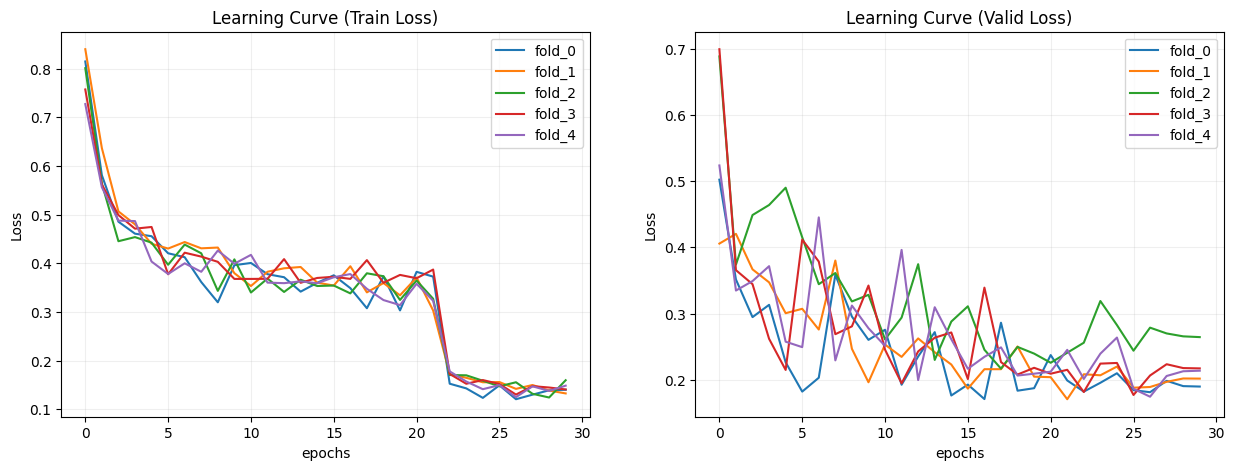

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1行2列のサブプロットを作成

for i, his in enumerate(list_history):
    axes[0].plot(his["Train Loss"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画
    axes[1].plot(his["Valid Loss"], label=f"fold_{i}")  # 2つ目のサブプロットにValid Lossを描画

axes[0].set_title("Learning Curve (Train Loss)")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("epochs")
axes[0].legend()
axes[0].grid(alpha=0.2)
# axes[0].set_ylim([0, 1])

axes[1].set_title("Learning Curve (Valid Loss)")
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("epochs")
axes[1].legend()
axes[1].grid(alpha=0.2)
# axes[1].set_ylim([0, 1])


# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# wandbに記録
# wandb.log({"learning_curve_loss": wandb.Image(img)})

plt.show()

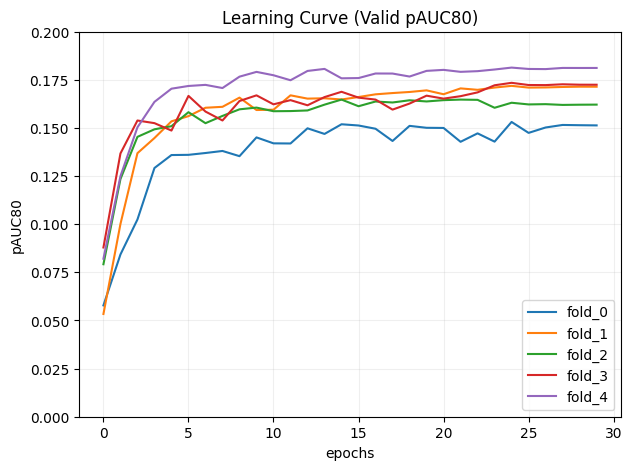

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))  # 1列のサブプロットを作成

for i, his in enumerate(list_history):
    ax.plot(his["Valid AUROC"], label=f"fold_{i}")  # Valid AUROCのみを描画

ax.set_title("Learning Curve (Valid pAUC80)")
ax.set_ylabel("pAUC80")
ax.set_xlabel("epochs")
ax.legend()
ax.grid(alpha=0.2)
ax.set_ylim([0, 0.2])

# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# # wandbに記録
# wandb.log({"learning_curve_pAUC80": wandb.Image(img)})

plt.show()

In [32]:
# data = [[x, y] for (x, y) in zip(range(len(his["Valid AUROC"].values)), his["Valid AUROC"].values)]
# table = wandb.Table(data=data, columns=["x", "y"])
# wandb.log(
#     {
#         "learning_curve_pAUC80": wandb.plot.line(
#             table, "x", "y", title="Learning Curve (Valid pAUC80)"
#         )
#     }
# )

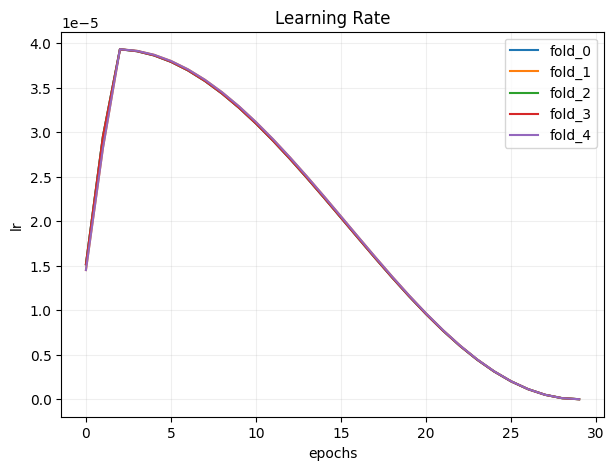

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(alpha=0.2)
for i, his in enumerate(list_history):
    ax.plot(his["lr"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画

ax.set_title("Learning Rate")
ax.set_ylabel("lr")
ax.set_xlabel("epochs")
ax.legend()

plt.show()

In [34]:
if CONFIG["save_preds"]:
    df_pred = pd.concat(list_preds)
    df_pred.to_csv(f"{CONFIG['save_model_dir']}/df_preds_{EXP_NAME}.csv", index=False)

In [35]:
pd.options.display.precision = 4

df_pauc = pd.DataFrame(columns=["pAUC80"])
for i, his in enumerate(list_history):
    df_pauc.loc[f"fold_{i}", "pAUC80"] = his["Valid AUROC"].values[-1]

df_pauc["pAUC80_notFiltered"] = list_score_notFiltered
df_pauc.loc["mean", "pAUC80_notFiltered"] = np.mean(df_pauc["pAUC80_notFiltered"])
df_pauc.loc["std", "pAUC80_notFiltered"] = np.std(df_pauc["pAUC80_notFiltered"])
df_pauc.loc["mean", "pAUC80"] = np.mean(df_pauc["pAUC80"])
df_pauc.loc["std", "pAUC80"] = np.std(df_pauc["pAUC80"])
df_pauc

,pAUC80,pAUC80_notFiltered
fold_0,0.1513,0.1509
fold_1,0.1714,0.1701
fold_2,0.1621,0.1616
fold_3,0.1725,0.1715
fold_4,0.1812,0.1777
mean,0.1677,0.1664
std,0.0093,0.0084


In [36]:
if WANDB:
    wandb.log({"pAUC80_fold0": df_pauc.loc["fold_0", "pAUC80"]})
    wandb.log({"pAUC80_fold1": df_pauc.loc["fold_1", "pAUC80"]})
    wandb.log({"pAUC80_fold2": df_pauc.loc["fold_2", "pAUC80"]})
    wandb.log({"pAUC80_fold3": df_pauc.loc["fold_3", "pAUC80"]})
    wandb.log({"pAUC80_fold4": df_pauc.loc["fold_4", "pAUC80"]})
    wandb.log({"pAUC80_mean": df_pauc.loc["mean", "pAUC80"]})

    wandb.finish()

pAUC80_fold0,▁
pAUC80_fold1,▁
pAUC80_fold2,▁
pAUC80_fold3,▁
pAUC80_fold4,▁
pAUC80_mean,▁
pAUC80_fold0,0.15134
pAUC80_fold1,0.17143
pAUC80_fold2,0.16213
pAUC80_fold3,0.17246
pAUC80_fold4,0.18118


In [37]:
# wandb.finish()